In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
from transformers import AutoTokenizer, T5EncoderModel
from transformers import AutoImageProcessor, BeitForMaskedImageModeling
from transformers import CLIPProcessor, CLIPModel
from dall_e import map_pixels, unmap_pixels, load_model
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np
import gc
from discriminator_utils import COCO2017
from torch.utils.data import DataLoader
device = torch.device('cuda')

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
class CustomEmbedding(nn.Module):
    def __init__(self):
        super(CustomEmbedding, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=312, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=312, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1)

        # self.tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-base') # T5Tokenizer.from_pretrained('t5-base')
        self.t5_model = T5EncoderModel.from_pretrained('t5-base').to('cuda')

        self.linear1 = nn.Linear(131840, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 3 * 256 * 256)

    def forward(self, image, caption, mode="train"):
        self.train() if mode == 'train' else self.eval()
        # tokenized_input = self.tokenizer(caption, return_tensors='pt', padding=True, truncation=True, max_length=512)

        with torch.no_grad():
            # text_outputs = self.t5_model(**tokenized_input)
            text_outputs = self.t5_model(**caption)
            text_embeddings = text_outputs.last_hidden_state.mean(dim=1)


        if mode != "train":
            image = torch.zeros_like(image)

        image = torch.reshape(image, (32,3,64,64)) # changed
        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)

        combined_features = torch.cat([x, text_embeddings], dim=1)

        x = F.relu(self.linear1(combined_features))
        x = F.relu(self.linear2(x))
        output = F.sigmoid(self.linear3(x))

        output = output.view(-1, 3, 256, 256)

        return output

class TextToImage(nn.Module):
    def __init__(self):
        super(TextToImage, self).__init__()
        self.image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k", device=device)
        self.embedding_network = CustomEmbedding().to(device)
        self.beit_model = BeitForMaskedImageModeling.from_pretrained("microsoft/beit-base-patch16-224-pt22k").to(device)
        self.decoder = load_model("https://cdn.openai.com/dall-e/decoder.pkl", device)

    def forward(self, image, caption, mode='train'):
        self.train() if mode == 'train' else self.eval()

        resize_transform = transforms.Resize((64, 64))
        # image_resized = resize_transform(image)

        # to_tensor_transform = transforms.ToTensor()
        # image_tensor = to_tensor_transform(image_resized)

        image_tensor = image
        combined_embeddings = self.embedding_network(image_tensor, caption, mode)

        pixel_values = self.image_processor(images=combined_embeddings, return_tensors="pt").pixel_values
        num_patches = (self.beit_model.config.image_size // self.beit_model.config.patch_size) ** 2

        if(mode=="train"):
          bool_masked_pos = torch.randint(low=100, high=180, size=(1, num_patches)).bool().to(device)
        else:
          bool_masked_pos = None

        #Put the Beit model in training mode
        self.beit_model.train() if mode == 'train' else self.beit_model.eval()


        outputs = self.beit_model(pixel_values.to('cuda'), bool_masked_pos)

        # print(outputs.loss)
        logits = outputs.logits

        logits_1= logits.view(32, 14, 14, 8192).permute(0,3,1,2) # changed

        logits_1 = torch.argmax(logits_1, axis=1)
        logits_1 = F.one_hot(logits_1, num_classes=8192).permute(0, 3, 1, 2).float().to(device)

        output = self.decoder(logits_1).float()
        output = unmap_pixels(torch.sigmoid(output[:, :3]))

        #resized 256, 256
        decoded_img = resize_transform(output)

        return decoded_img

In [3]:
model = TextToImage()
model.to('cuda')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


TextToImage(
  (embedding_network): CustomEmbedding(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 312, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(312, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (t5_model): T5EncoderModel(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(in_features=768, out_features=768, bias=False)
                  (k): Linear(in_features=768, out_features=768, bias=False)
                  (v): Linear(in_features=768, out_features=768, bias=False)
 

In [4]:
initial_lr = 0.00001
final_lr = 0.001

milestones = [5, 10,25]

gamma = (final_lr / initial_lr) ** (1 / len(milestones))

optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-base')

In [3]:
dataset = COCO2017('./train_annotations.json', r'C:\Users\danie\Documents\Data\COMP652\FinalProject\train2017', 6400)
data_loader = DataLoader(dataset, batch_size=32)

# get validation data
val_dataset = COCO2017('./val_annotations.json', r'C:\Users\danie\Documents\Data\COMP652\FinalProject\train2017', 640)
val_data_loader = DataLoader(val_dataset, batch_size=32)

In [6]:
model.train()

train_epoch_loss = []
val_epoch_loss = []
#Training loop
num_epochs = 5
for epoch in range(num_epochs):
    batch_loss = []
    val_batch_loss_list = []
    for idx, (image, text) in enumerate(data_loader, 0):
        # image = (64,3,64,64) = 64x64 images
        optimizer.zero_grad()
        text = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=70)
        text = text.to('cuda')
        image = image.to('cuda')
        output = model(image, text, mode='train')
        loss = criterion(output.squeeze(0), image)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        batch_loss.append(loss.item())
        if idx % 10 == 0:
            print(f"Batch {idx}, Loss: {loss.item()}")
    
    print(f"Epoch {epoch}, Average Training Batch Loss: {np.mean(batch_loss)}")
    train_epoch_loss.append(np.mean(batch_loss))
    with torch.no_grad():
        for _, (val_image, val_text) in enumerate(val_data_loader, 0):
            val_text = tokenizer(val_text, return_tensors='pt', padding=True, truncation=True, max_length=70)
            val_text = val_text.to('cuda')
            val_image = val_image.to('cuda')
            val_output = model(val_image, val_text, mode='train')
            val_batch_loss = criterion(val_output.squeeze(0), val_image)
            val_batch_loss_list.append(val_batch_loss.item())
    print(f"Epoch {epoch}, Average Validation Batch Loss: {np.mean(val_batch_loss_list)}")
    val_epoch_loss.append(np.mean(val_batch_loss_list))

Batch 0, Loss: 0.12107186019420624
Batch 10, Loss: 0.12796401977539062
Batch 20, Loss: 0.08395327627658844
Batch 30, Loss: 0.06402673572301865
Batch 40, Loss: 0.0915290117263794
Batch 50, Loss: 0.06174555420875549
Batch 60, Loss: 0.0810886025428772
Batch 70, Loss: 0.05746942013502121
Batch 80, Loss: 0.09435798227787018
Batch 90, Loss: 0.09019383043050766
Batch 100, Loss: 0.07397621870040894
Batch 110, Loss: 0.06302671879529953
Batch 120, Loss: 0.08737819641828537
Batch 130, Loss: 0.0677742063999176
Batch 140, Loss: 0.062815360724926
Batch 150, Loss: 0.07233846187591553
Batch 160, Loss: 0.07974639534950256
Batch 170, Loss: 0.045397352427244186
Batch 180, Loss: 0.06397885829210281
Batch 190, Loss: 0.06822699308395386
Epoch 0, Average Training Batch Loss: 0.08023801857605577
Epoch 0, Average Validation Batch Loss: 0.06771597620099783
Batch 0, Loss: 0.06841705739498138
Batch 10, Loss: 0.08628854155540466
Batch 20, Loss: 0.08142131567001343
Batch 30, Loss: 0.05008811876177788
Batch 40, Loss

In [8]:
torch.save(model, r'C:\Users\danie\OneDrive\Documents\RiceUniversity\COMP 652\Text2Image_GAN\transformer.pth')

In [4]:
model = torch.load("transformer.pth")

In [8]:
class CGenerator(nn.Module):
    # define constructor for the generator
    def __init__(self, noise_in_dimension, noise_out_dimension, vocab_size, embedding_length=128):
        # inherit nn.Module class methods
        super().__init__()
        # set class attributes:
        # model branch at start of model structure for noise (image)
        self.initial_noise_processing = nn.Sequential(nn.Linear(in_features=noise_in_dimension, out_features=4*4*noise_out_dimension, bias=True), nn.CELU(alpha=1, inplace=True))
        # moddel branch at start of model structure (parallel to noise branch) for condition (text)
        self.initial_condition_processing = nn.Sequential(nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_length, padding_idx=1), nn.Linear(in_features=embedding_length, out_features=16), nn.LeakyReLU(negative_slope=0.1, inplace=True))
        self.generator_model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=59+noise_out_dimension, out_channels=64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*8), # momentum parameter
            nn.ReLU(inplace=True), # 64x512x8x8
            nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*4),
            nn.ReLU(inplace=True), # 64x256x16x16
            nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*2),
            nn.ReLU(inplace=True), # 64x128x32x32
            # nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(num_features=64),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh() #64x3x64x64
            )
        
    def forward(self, noise, text, batch_size=64):
        preconcat_noise = self.initial_noise_processing(noise)
        # reshape noise data
        preconcat_noise = torch.reshape(preconcat_noise, (-1, 512, 4, 4))
        preconcat_text = self.initial_condition_processing(text)
        # reshape text data
        preconcat_text = torch.reshape(preconcat_text, (batch_size, 944))
        preconcat_text = torch.reshape(preconcat_text, (-1, 59, 4, 4))
        # concatenate the image data and text data
        image_and_text = torch.concat((preconcat_noise, preconcat_text), dim=1)
        generative_result = self.generator_model(image_and_text)
        return generative_result


generator = torch.load("generator.pth")

In [5]:
test_dataset = COCO2017('./test_annotations.json', r'C:\Users\danie\Documents\Data\COMP652\FinalProject\val2017', 64)
transformer_test_data_loader = DataLoader(val_dataset, batch_size=32)
gan_test_data_loader = DataLoader(val_dataset, batch_size=64)

In [12]:
def visualization_helper(data):
    print(plt.imshow(np.transpose(data)))

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to('cuda')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def clip_score(image, caption):
  inputs = processor(text=caption, images=image, return_tensors="pt", padding=True)
  inputs.to('cuda')
  clip_model.eval()
  with torch.no_grad():
    outputs = clip_model(**inputs)
  cosine = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
  score = cosine(outputs.image_embeds, outputs.text_embeds)
  return max((score.item()* 100), 0)

Caption: a big clock tower that is high in the sky
AxesImage(size=(64, 64))


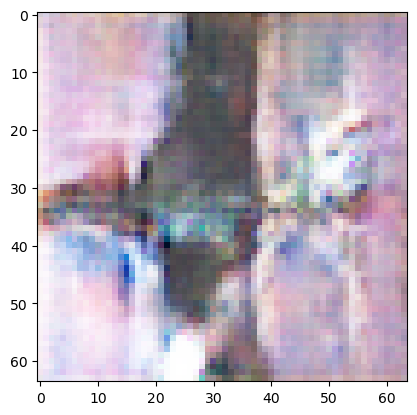

Clip Score: 21.697983145713806
Caption: A living room has green walls and large blue couches.
AxesImage(size=(64, 64))


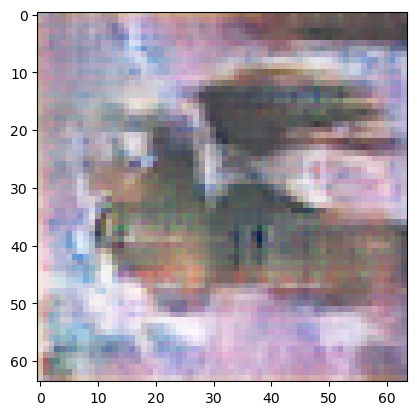

Clip Score: 21.411412954330444
Caption: A boy is taking a picture of a pizza with his camera.
AxesImage(size=(64, 64))


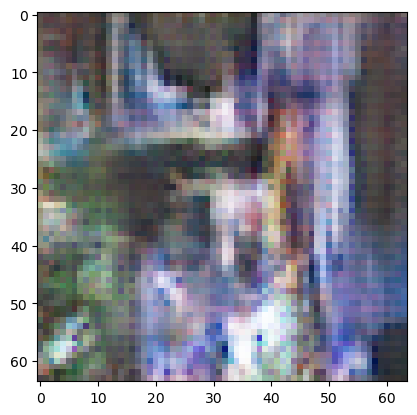

Clip Score: 21.227021515369415
Caption: Many cows are near a river and an old car.
AxesImage(size=(64, 64))


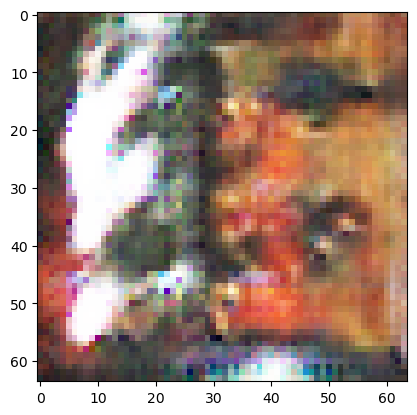

Clip Score: 19.677042961120605
Caption: Pink suitcase with clothing articles sits on wooden flooring.
AxesImage(size=(64, 64))


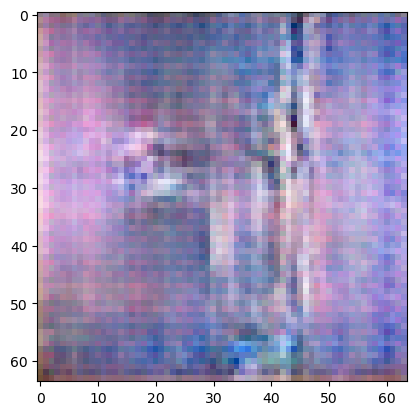

Clip Score: 19.246956706047058


In [24]:
# GAN
# get noise from normal distribution to be used for all test images
test_noise = torch.randn(64, 100, device='cuda')
gan_test_image_results = []
test_text_first_batch_record = []
gan_clip_score = []
text_tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
with torch.no_grad():
    for _, (image, text) in enumerate(gan_test_data_loader, 0):
        test_text_first_batch_record.append(text[0])
        token_text = text_tokenizer(text, max_length=59, padding='max_length', truncation=True).input_ids
        token_text = torch.as_tensor(token_text)
        token_text = token_text.to('cuda')
        test_synthetic = generator(test_noise, token_text, batch_size=64).detach().to('cpu')
        gan_test_image_results.append(test_synthetic)
        cs = clip_score(torchvision.utils.make_grid(tensor=test_synthetic[0], normalize=True), text[0])
        gan_clip_score.append(cs)
        # current_image_result = torchvision.utils.make_grid(tensor=test_synthetic, normalize=True)
        # gan_test_image_results.append(current_image_result)

# printing out the first image in the first 5 batches
for i in range(5):
    print(f"Caption: {test_text_first_batch_record[i]}")
    visualization_helper(torchvision.utils.make_grid(tensor=gan_test_image_results[0][i], normalize=True))
    plt.show()
    print(f"Clip Score: {gan_clip_score[i]}")

Caption: a big clock tower that is high in the sky
AxesImage(size=(64, 64))


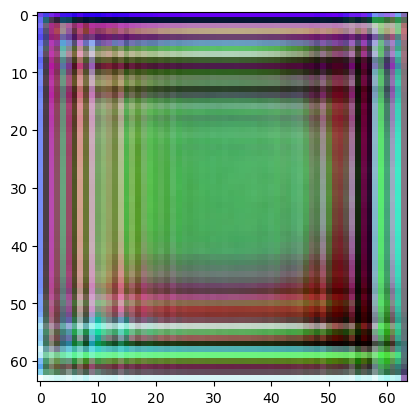

Clip Score: 21.471798419952393
Caption: A living room has green walls and large blue couches.
AxesImage(size=(64, 64))


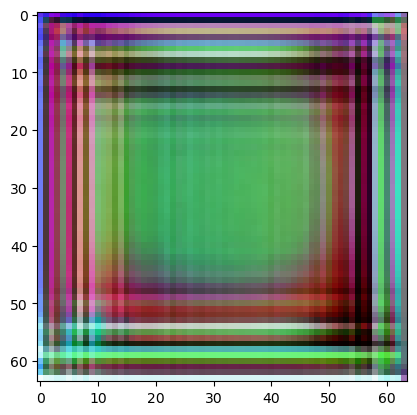

Clip Score: 21.850253641605377
Caption: A boy is taking a picture of a pizza with his camera.
AxesImage(size=(64, 64))


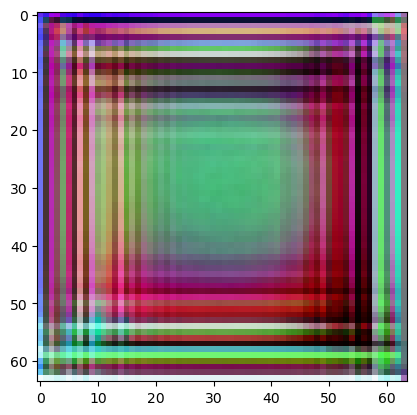

Clip Score: 20.213736593723297
Caption: Many cows are near a river and an old car.
AxesImage(size=(64, 64))


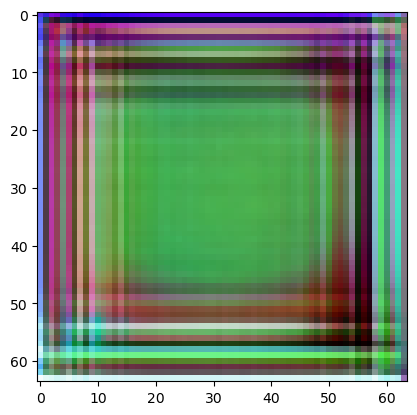

Clip Score: 18.627947568893433
Caption: Pink suitcase with clothing articles sits on wooden flooring.
AxesImage(size=(64, 64))


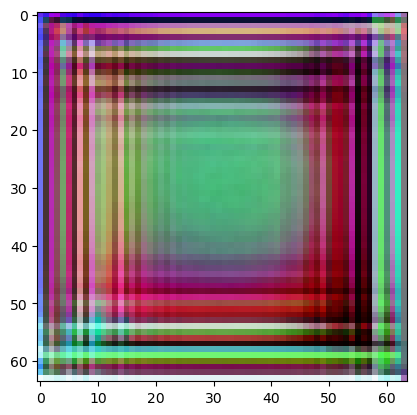

Clip Score: 21.169956028461456


In [27]:
# Transformer
transformer_clip_score = []
transformer_test_output = []
model.eval()
with torch.no_grad():
    for _, (image, text) in enumerate(transformer_test_data_loader, 0):
        token_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=70)
        token_text = token_text.to('cuda')
        image = image.to('cuda') # image not actually being used in eval mode, but need input for model.
        output = model(image, token_text, mode='train').detach().to('cpu')
        # transformer_test_output.append(torchvision.utils.make_grid(tensor=output.to('cpu'), normalize=True))
        transformer_test_output.append(output)
        cs = clip_score(torchvision.utils.make_grid(tensor=output[0], normalize=True), text[0])
        transformer_clip_score.append(cs)
for i in range(5):
    print(f"Caption: {test_text_first_batch_record[i]}")
    visualization_helper(torchvision.utils.make_grid(tensor=transformer_test_output[0][i], normalize=True))
    plt.show()
    print(f"Clip Score: {transformer_clip_score[i]}")

In [25]:
del model
del generator
gc.collect()
torch.cuda.empty_cache()